In [10]:
import os
import time
import PIL
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras import Model, layers
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [11]:
# Set random seeds for reproducibility
tf.random.set_seed(33)
np.random.seed(33)

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
BUFFER_SIZE = 360
BATCH_SIZE = 16
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = 'logs/'

In [12]:
# Make sure log directory exists
os.makedirs(LOG_DIR, exist_ok=True)

In [13]:
data_path = 'data/'

In [14]:
monet_filenames= tf.io.gfile.glob(str(data_path + '/monet_jpg/*.jpg'))
photo_filenames = tf.io.gfile.glob(str(data_path + '/photo_jpg/*.jpg'))

In [15]:
print(f'Number of Monet files: {len(monet_filenames)}')
print(f'Number of photograph files: {len(photo_filenames)}')

Number of Monet files: 300
Number of photograph files: 7038


Monet image shape: (256, 256, 3)
Photo image shape: (256, 256, 3)


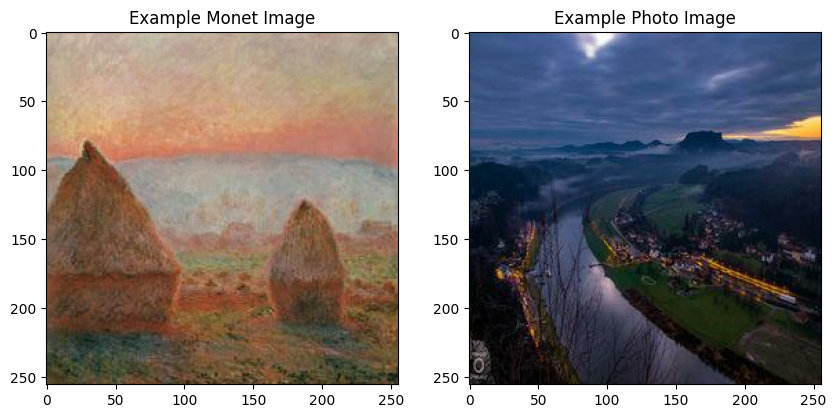

In [16]:
if monet_filenames and photo_filenames:
    example_monet_path = monet_filenames[random.randint(0, len(monet_filenames)) ]
    monet_image = tf.io.read_file(example_monet_path)
    monet_image = tf.image.decode_jpeg(monet_image, channels=3)
    print("Monet image shape:", monet_image.shape)

    example_photo_path = photo_filenames[random.randint(0, len(photo_filenames))]
    photo_image = tf.io.read_file(example_photo_path)
    photo_image = tf.image.decode_jpeg(photo_image, channels=3)
    print("Photo image shape:", photo_image.shape)
    
    # Display the images side by side
    plt.figure(figsize=(10, 5)) 

    # Show Monet image in the first subplot
    plt.subplot(1, 2, 2)
    plt.imshow(photo_image.numpy())
    plt.title("Example Photo Image")

    # Show Photo image in the second subplot
    plt.subplot(1, 2, 1)
    plt.imshow(monet_image.numpy())
    plt.title("Example Monet Image")

    plt.show()

In [17]:
# Initialize accumulators
total_pixels = 0
sum_rgb = np.zeros(3)
sum_sq_rgb = np.zeros(3)

for filename in monet_filenames:
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256]).numpy()
    
    sum_rgb += image.mean(axis=(0, 1))
    sum_sq_rgb += (image**2).mean(axis=(0, 1))
    total_pixels += 1

# Calculate final statistics
mean = sum_rgb / total_pixels
std = np.sqrt(sum_sq_rgb/total_pixels - mean**2)

print(f"Dataset Mean (RGB): {mean}")
print(f"Dataset Std (RGB): {std}")

Dataset Mean (RGB): [131.80562912 133.75694707 120.24496012]
Dataset Std (RGB): [57.85646349 56.16768997 62.97409039]


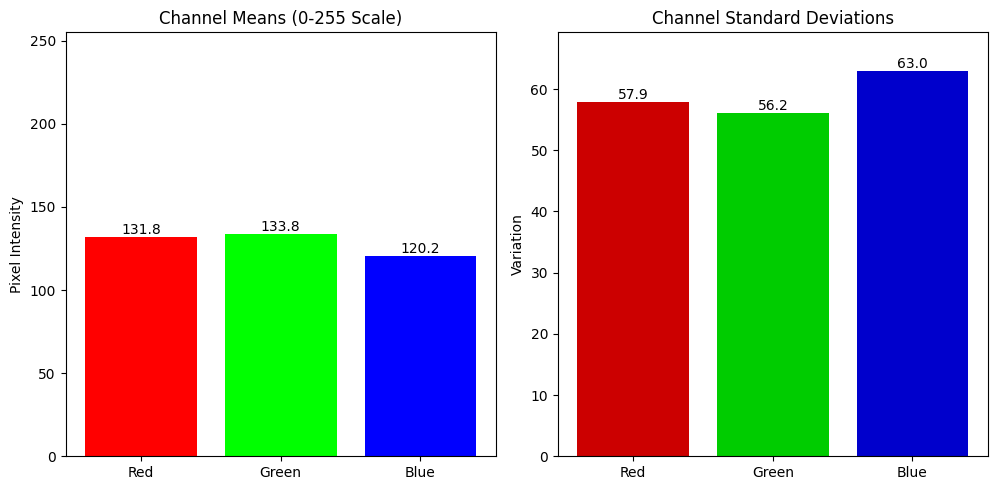

In [18]:
# Create figure with subplots
plt.figure(figsize=(15, 5))

# Plot 1: Channel means with color bars
plt.subplot(1, 3, 1)
bars = plt.bar(['Red', 'Green', 'Blue'], mean, 
               color=['#ff0000', '#00ff00', '#0000ff'])
plt.title('Channel Means (0-255 Scale)')
plt.ylabel('Pixel Intensity')
plt.ylim(0, 255)

# Add exact values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

# Plot 2: Channel standard deviations
plt.subplot(1, 3, 2)
bars = plt.bar(['Red', 'Green', 'Blue'], std,
               color=['#cc0000', '#00cc00', '#0000cc'])
plt.title('Channel Standard Deviations')
plt.ylabel('Variation')
plt.ylim(0, np.max(std) * 1.1)

# Add exact values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [19]:
def preprocess_image(image_bytes):
    """Process raw image bytes into normalized tensors."""
    try:
        # Decode with explicit RGB conversion
        image = tf.image.decode_jpeg(image_bytes, channels=3)
        
        # Convert to float and resize
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                              method=tf.image.ResizeMethod.BILINEAR)
        
        # Normalize to [-1, 1] range for tanh activation
        image = (image - 0.5) * 2.0
        
        # Ensure proper shape
        image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
        
        return image
        
    except tf.errors.InvalidArgumentError as e:
        print(f"Error processing image: {e}")
        return tf.zeros([IMG_HEIGHT, IMG_WIDTH, 3])  # Return blank image

def load_dataset(filenames, shuffle=True):
    """Create optimized TensorFlow Dataset pipeline."""
    # Validate input
    if not filenames:
        raise ValueError("Empty file list provided to load_dataset")
    
    # Create base dataset
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    
    # Shuffle filenames before reading
    if shuffle:
        dataset = dataset.shuffle(len(filenames), reshuffle_each_iteration=True)
    
    # Parallel file reading and preprocessing
    dataset = dataset.map(
        lambda x: tf.io.read_file(x),
        num_parallel_calls=AUTOTUNE
    )
    
    # Handle corrupt images
    dataset = dataset.map(
        preprocess_image,
        num_parallel_calls=AUTOTUNE
    ).apply(
        tf.data.experimental.ignore_errors()
    )
    
    # Performance optimizations
    dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

# Create datasets
monet_ds = load_dataset(monet_filenames, shuffle=True)
photo_ds = load_dataset(photo_filenames, shuffle=True)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [20]:
def get_dataset_length(dataset):
    """
    Returns the length of a tf.data.Dataset.
    If the cardinality is unknown, it iterates through the dataset to count elements.
    """
    cardinality = dataset.cardinality().numpy()
    if cardinality == tf.data.UNKNOWN_CARDINALITY:
        count = 0
        for _ in dataset:
            count += 1
        return count
    return cardinality


# Ensure equal number of batches
len_monet_ds, len_photo_ds = get_dataset_length(monet_ds), get_dataset_length(photo_ds)
num_batches = min(len_monet_ds, len_photo_ds)
monet_ds = monet_ds.take(num_batches)
photo_ds = photo_ds.take(num_batches)

In [21]:
# diagnostic logging
print("\nDataset Summary:")
print(f"Monet examples: {len(monet_filenames)}")
print(f"Photo examples: {len(photo_filenames)}")
print(f"Monet batches: {tf.data.experimental.cardinality(monet_ds)}")
print(f"Photo batches: {tf.data.experimental.cardinality(photo_ds)}")
print(f"Output signature: {monet_ds.element_spec}\n")


Dataset Summary:
Monet examples: 300
Photo examples: 7038
Monet batches: -2
Photo batches: -2
Output signature: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)



In [22]:
# Quick sanity check
# Verify the diagnostic output, Check for any corruption warnings, Ensure the pixel ranges are [-1, 1], Confirm batch shapes are (16, 256, 256, 3)
for batch in monet_ds.take(1):
    print("Monet batch shape:", batch.shape)
    print("Pixel range:", tf.reduce_min(batch).numpy(), 
          tf.reduce_max(batch).numpy())

for batch in photo_ds.take(1):
    print("Photo batch shape:", batch.shape)
    print("Pixel range:", tf.reduce_min(batch).numpy(),
          tf.reduce_max(batch).numpy())

Monet batch shape: (16, 256, 256, 3)
Pixel range: -1.0 1.0
Photo batch shape: (16, 256, 256, 3)
Pixel range: -1.0 1.0


In [23]:
def build_generator(input_shape=(256, 256, 3), base_filters=64, use_attention=True):
    """
    Build an improved generator with proper normalization and skip connections.
    
    Args:
        input_shape: Input image shape (default: (256, 256, 3))
        base_filters: Number of base filters (default: 64)
        use_attention: Whether to use self-attention (default: True)
        
    Returns:
        Keras Model for the generator
    """
    # Weight initialization
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Encoder blocks - extract features at different scales
    # Each block: Conv -> BatchNorm -> LeakyReLU
    
    # Block 1: (256x256x3) -> (128x128x64)
    e1 = layers.Conv2D(base_filters, 4, strides=2, padding='same', 
                      kernel_initializer=init)(inputs)
    e1 = layers.LeakyReLU(0.2)(e1)
    
    # Block 2: (128x128x64) -> (64x64x128)
    e2 = layers.Conv2D(base_filters*2, 4, strides=2, padding='same', 
                      kernel_initializer=init)(e1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.LeakyReLU(0.2)(e2)
    
    # Block 3: (64x64x128) -> (32x32x256)
    e3 = layers.Conv2D(base_filters*4, 4, strides=2, padding='same', 
                      kernel_initializer=init)(e2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.LeakyReLU(0.2)(e3)
    
    # Block 4: (32x32x256) -> (16x16x512)
    e4 = layers.Conv2D(base_filters*8, 4, strides=2, padding='same', 
                      kernel_initializer=init)(e3)
    e4 = layers.BatchNormalization()(e4)
    e4 = layers.LeakyReLU(0.2)(e4)
    
    # Block 5: (16x16x512) -> (8x8x512)
    e5 = layers.Conv2D(base_filters*8, 4, strides=2, padding='same', 
                      kernel_initializer=init)(e4)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.LeakyReLU(0.2)(e5)
    
    # Bottleneck - add self-attention at the bottleneck
    bottleneck = e5
    
    # Apply self-attention at the bottleneck if requested
    if use_attention:
        bottleneck = SelfAttention(base_filters*8)(bottleneck)
    
    # Decoder blocks - upsample and concatenate with encoder features
    # Each block: ConvTranspose -> BatchNorm -> ReLU -> Concat with encoder
    
    # Block 1: (8x8x512) -> (16x16x512)
    d1 = layers.Conv2DTranspose(base_filters*8, 4, strides=2, padding='same', 
                               kernel_initializer=init)(bottleneck)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.ReLU()(d1)
    # Skip connection with e4
    d1 = layers.Concatenate()([d1, e4])
    
    # Block 2: (16x16x1024) -> (32x32x256)
    d2 = layers.Conv2DTranspose(base_filters*4, 4, strides=2, padding='same', 
                               kernel_initializer=init)(d1)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.ReLU()(d2)
    # Skip connection with e3
    d2 = layers.Concatenate()([d2, e3])
    
    # Block 3: (32x32x512) -> (64x64x128)
    d3 = layers.Conv2DTranspose(base_filters*2, 4, strides=2, padding='same', 
                               kernel_initializer=init)(d2)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.ReLU()(d3)
    # Skip connection with e2
    d3 = layers.Concatenate()([d3, e2])
    
    # Block 4: (64x64x256) -> (128x128x64)
    d4 = layers.Conv2DTranspose(base_filters, 4, strides=2, padding='same', 
                               kernel_initializer=init)(d3)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.ReLU()(d4)
    # Skip connection with e1
    d4 = layers.Concatenate()([d4, e1])
    
    # Output layer: (128x128x128) -> (256x256x3)
    output = layers.Conv2DTranspose(3, 4, strides=2, padding='same', 
                                   kernel_initializer=init, activation='tanh')(d4)
    
    # Create and return model
    model = Model(inputs=inputs, outputs=output, name="Generator")
    return model

# Simplified Self-Attention layer with improved numerical stability
class SelfAttention(layers.Layer):
    """
    Self-attention mechanism for GANs with improved stability.
    """
    def __init__(self, filters, reduction_ratio=8):
        super().__init__()
        self.filters = filters
        self.reduction_ratio = reduction_ratio
        
        # Reduced dimension for query and key (for efficiency)
        self.reduced_filters = max(filters // reduction_ratio, 1)
        
        # Initialize gamma parameter with zeros for gradual learning
        self.gamma = self.add_weight(
            name='gamma',
            shape=(),
            initializer='zeros',
            trainable=True
        )
        
        # Create convolution layers
        self.query_conv = layers.Conv2D(self.reduced_filters, 1, padding='same')
        self.key_conv = layers.Conv2D(self.reduced_filters, 1, padding='same')
        self.value_conv = layers.Conv2D(filters, 1, padding='same')
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        
        # Create query, key, and value projections
        query = self.query_conv(x)  # B×H×W×(C/r)
        key = self.key_conv(x)      # B×H×W×(C/r)
        value = self.value_conv(x)  # B×H×W×C
        
        # Reshape for attention computation
        hw = tf.shape(x)[1] * tf.shape(x)[2]
        
        # Reshape to matrices for matrix multiplication
        query_flat = tf.reshape(query, [batch_size, hw, self.reduced_filters])  # B×(H*W)×(C/r)
        key_flat = tf.reshape(key, [batch_size, hw, self.reduced_filters])      # B×(H*W)×(C/r)
        value_flat = tf.reshape(value, [batch_size, hw, self.filters])          # B×(H*W)×C
        
        # Calculate attention scores (B×(H*W)×(H*W))
        energy = tf.matmul(query_flat, key_flat, transpose_b=True)
        
        # Scale dot-product attention
        scale = tf.sqrt(tf.cast(self.reduced_filters, tf.float32))
        attention = tf.nn.softmax(energy / scale, axis=-1)
        
        # Apply attention to value
        out = tf.matmul(attention, value_flat)  # B×(H*W)×C
        
        # Reshape back to original shape
        out = tf.reshape(out, tf.shape(x))
        
        # Apply weighted residual connection
        return self.gamma * out + x

In [24]:
def build_discriminator(input_shape=(256, 256, 3), base_filters=64, use_sn=True, patchgan_output=True):
    """
    Build an improved PatchGAN discriminator with spectral normalization.
    
    Args:
        input_shape: Input image shape (default: (256, 256, 3))
        base_filters: Base filter count (default: 64)
        use_sn: Whether to use spectral normalization (default: True)
        patchgan_output: Whether to use PatchGAN output (default: True)
        
    Returns:
        Keras Model for the discriminator
    """
    # Weight initialization for GAN stability
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # First conv without normalization
    x = layers.Conv2D(base_filters, 4, strides=2, padding='same', 
                      kernel_initializer=init)(inputs)
    x = layers.LeakyReLU(0.2)(x)
    
    # Stack of increasing filter size Conv blocks
    # Each block: Conv -> (Spectral)Norm -> LeakyReLU
    filter_sizes = [base_filters*2, base_filters*4, base_filters*8]
    
    for i, filters in enumerate(filter_sizes):
        conv = layers.Conv2D(filters, 4, strides=2, padding='same', 
                            kernel_initializer=init)
        
        # Apply spectral normalization if requested
        if use_sn:
            conv = layers.SpectralNormalization(conv)
            
        x = conv(x)
        
        # Use instance normalization instead of batch normalization for better stability
        # Don't use normalization with spectral norm in the same layer
        if not use_sn:
            x = layers.BatchNormalization()(x)
            
        x = layers.LeakyReLU(0.2)(x)
    
    # Apply self-attention after sufficient downsampling
    x = SelfAttention(base_filters*8)(x)
    
    # Final convolution layer
    if patchgan_output:
        # PatchGAN output - don't use global pooling
        x = layers.Conv2D(1, 4, padding='same', kernel_initializer=init)(x)
    else:
        # Classify entire image (original approach)
        x = layers.Conv2D(base_filters*8, 4, padding='same', kernel_initializer=init)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Conv2D(1, 4, padding='same', kernel_initializer=init)(x)
        x = layers.GlobalAveragePooling2D()(x)
    
    # Create and return model
    model = Model(inputs=inputs, outputs=x, name="Discriminator")
    return model

# Simplified residual block for optional use
def residual_block(x, filters, use_sn=True, downsample=False):
    """
    Residual block with optional spectral normalization and downsampling.
    
    Args:
        x: Input tensor
        filters: Number of filters
        use_sn: Whether to use spectral normalization
        downsample: Whether to downsample spatially
        
    Returns:
        Output tensor
    """
    shortcut = x
    
    # First convolution
    conv1 = layers.Conv2D(filters, 3, padding='same')
    if use_sn:
        conv1 = layers.SpectralNormalization(conv1)
    
    x = conv1(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Second convolution
    conv2 = layers.Conv2D(filters, 3, padding='same')
    if use_sn:
        conv2 = layers.SpectralNormalization(conv2)
    
    x = conv2(x)
    
    # Downsample if requested (after both convolutions)
    if downsample:
        x = layers.AveragePooling2D()(x)
        shortcut = layers.AveragePooling2D()(shortcut)
    
    # Adjust shortcut dimension if needed
    if shortcut.shape[-1] != filters:
        shortcut_conv = layers.Conv2D(filters, 1, padding='same')
        if use_sn:
            shortcut_conv = layers.SpectralNormalization(shortcut_conv)
        shortcut = shortcut_conv(shortcut)
    
    # Add residual connection
    return layers.Add()([x, shortcut])

In [25]:
class WGANGPLoss:
    def __init__(self, lambda_gp=10.0, drift_penalty=0.001, epsilon=1e-8):
        """
        Initialize WGAN-GP loss with parameters.
        
        Args:
            lambda_gp: Gradient penalty coefficient (default: 10.0)
            drift_penalty: Coefficient for drift penalty (default: 0.001)
            epsilon: Small constant for numerical stability
        """
        self.lambda_gp = lambda_gp
        self.drift_penalty = drift_penalty
        self.epsilon = epsilon
        
    def discriminator_loss(self, real_scores, fake_scores):
        """
        Wasserstein discriminator loss: maximize real scores, minimize fake scores.
        
        Args:
            real_scores: Output from real images (shape: [batch_size, 1])
            fake_scores: Output from generated images (shape: [batch_size, 1])
            
        Returns:
            Discriminator loss (scalar)
        """
        # In WGAN, discriminator wants to maximize: E[D(real)] - E[D(fake)]
        # Since we're minimizing, we use: E[D(fake)] - E[D(real)]
        real_loss = tf.reduce_mean(real_scores)
        fake_loss = tf.reduce_mean(fake_scores)
        
        # Calculate Wasserstein distance estimate
        wasserstein_distance = fake_loss - real_loss
        
        # Add metrics for monitoring (these work with TensorBoard)
        tf.summary.scalar('d_real_mean', real_loss)
        tf.summary.scalar('d_fake_mean', fake_loss)
        tf.summary.scalar('wasserstein_distance', wasserstein_distance)
        
        return wasserstein_distance
    
    def generator_loss(self, fake_scores):
        """
        Wasserstein generator loss: maximize fake scores.
        
        Args:
            fake_scores: Discriminator output for generated images
            
        Returns:
            Generator loss (scalar)
        """
        # In WGAN, generator wants to maximize: E[D(fake)]
        # Since we're minimizing, we use: -E[D(fake)]
        loss = -tf.reduce_mean(fake_scores)
        
        # Monitoring
        tf.summary.scalar('g_fake_mean', -loss)
        
        return loss

    def gradient_penalty(self, real_images, fake_images, discriminator):
        """
        Calculate WGAN-GP gradient penalty with improved numerical stability.
        
        Args:
            real_images: Batch of real images
            fake_images: Batch of generated images
            discriminator: Discriminator model
            
        Returns:
            Gradient penalty term (scalar)
        """
        # Get batch size dynamically
        batch_size = tf.shape(real_images)[0]
        
        # Generate random interpolation factors
        alpha = tf.random.uniform(
            shape=[batch_size, 1, 1, 1],
            minval=0.0,
            maxval=1.0
        )
        
        # Create interpolated images
        interpolated = real_images + alpha * (fake_images - real_images)
        
        # Calculate gradients
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            # Get discriminator prediction for interpolated images
            pred = discriminator(interpolated, training=True)
        
        # Calculate gradients of predictions with respect to images
        gradients = tape.gradient(pred, interpolated)
        
        # Calculate the Euclidean norm of the gradients (add epsilon for stability)
        gradients_sqr = tf.square(gradients)
        gradients_sqr_sum = tf.reduce_sum(gradients_sqr, axis=[1, 2, 3])
        gradient_l2_norm = tf.sqrt(gradients_sqr_sum + self.epsilon)
        
        # Calculate penalty using (||∇D(x)||_2 - 1)²
        gradient_penalty = tf.reduce_mean(tf.square(gradient_l2_norm - 1.0))
        
        # Monitor gradient norms
        tf.summary.scalar('gradient_penalty', gradient_penalty)
        tf.summary.histogram('gradient_norms', gradient_l2_norm)
        
        return self.lambda_gp * gradient_penalty

    def drift_penalty(self, real_scores):
        """
        Apply drift penalty to prevent discriminator scores from drifting too far.
        
        Args:
            real_scores: Discriminator output for real images
            
        Returns:
            Drift penalty term (scalar)
        """
        # Penalize large values in discriminator output
        penalty = tf.reduce_mean(tf.square(real_scores))
        return self.drift_penalty * penalty

# Initialize the loss with adjusted parameters
LOSS = WGANGPLoss(lambda_gp=10.0, drift_penalty=0.001)

In [26]:
# Loss verification test
def test_losses():
    # Initialize components
    loss = WGANGPLoss()
    discriminator = build_discriminator()
    batch_size = 16
    
    # Test data
    real = tf.random.normal([batch_size, 256, 256, 3])
    fake = tf.random.normal([batch_size, 256, 256, 3])
    
    # Test discriminator loss
    real_scores = discriminator(real)
    fake_scores = discriminator(fake)
    d_loss = loss.discriminator_loss(real_scores, fake_scores)
    assert d_loss.shape == ()
    
    # Test gradient penalty
    gp = loss.gradient_penalty(real, fake, discriminator)
    assert gp.shape == ()
    
    # Test generator loss
    g_loss = loss.generator_loss(fake_scores)
    assert g_loss.shape == ()
    
    print("All loss tests passed!")

test_losses()

All loss tests passed!


In [27]:
# Build models with the improved implementations
generator = build_generator(input_shape=(256, 256, 3), base_filters=64)
discriminator = build_discriminator(input_shape=(256, 256, 3), base_filters=64, patchgan_output=True)

# Create optimizers with adjusted parameters for better stability
g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)

# Initialize loss with adjusted parameters
LOSS = WGANGPLoss(lambda_gp=10.0, drift_penalty=0.001)

# Define training metrics for monitoring
train_metrics = {
    'g_loss': tf.keras.metrics.Mean(name='g_loss'),
    'd_loss': tf.keras.metrics.Mean(name='d_loss'),
    'gp_loss': tf.keras.metrics.Mean(name='gp_loss'),
    'real_score': tf.keras.metrics.Mean(name='real_score'),
    'fake_score': tf.keras.metrics.Mean(name='fake_score')
}

# Set constants for training
EPOCHS = 30
D_STEPS = 1  # Number of discriminator steps per generator step

@tf.function
def train_step(real_monet, real_photo):
    """
    Single training step for Monet GAN.
    
    Args:
        real_monet: Batch of real Monet paintings
        real_photo: Batch of real photographs
        
    Returns:
        Dictionary of loss values for logging
    """
    # Train discriminator multiple times per generator step
    for _ in range(D_STEPS):
        with tf.GradientTape() as d_tape:
            # Generate fake Monet paintings
            fake_monet = generator(real_photo, training=True)
            
            # Get discriminator outputs
            real_output = discriminator(real_monet, training=True)
            fake_output = discriminator(fake_monet, training=True)
            
            # Calculate discriminator losses
            d_gan_loss = LOSS.discriminator_loss(real_output, fake_output)
            gp_loss = LOSS.gradient_penalty(real_monet, fake_monet, discriminator)
            drift_loss = LOSS.drift_penalty(real_output)
            
            # Total discriminator loss
            total_d_loss = d_gan_loss + gp_loss + drift_loss
        
        # Apply discriminator gradients
        d_gradients = d_tape.gradient(total_d_loss, discriminator.trainable_variables)
        
        # Clip gradients for stability (optional)
        d_gradients, _ = tf.clip_by_global_norm(d_gradients, 1.0)
        
        d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
    
    # Train generator
    with tf.GradientTape() as g_tape:
        # Generate fake images
        fake_monet = generator(real_photo, training=True)
        
        # Get discriminator output for generated images
        fake_output = discriminator(fake_monet, training=True)
        
        # Calculate generator loss
        g_loss = LOSS.generator_loss(fake_output)
    
    # Apply generator gradients
    g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    
    # Clip gradients for stability (optional)
    g_gradients, _ = tf.clip_by_global_norm(g_gradients, 1.0)
    
    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    
    # Update metrics
    train_metrics['g_loss'].update_state(g_loss)
    train_metrics['d_loss'].update_state(d_gan_loss)
    train_metrics['gp_loss'].update_state(gp_loss)
    train_metrics['real_score'].update_state(tf.reduce_mean(real_output))
    train_metrics['fake_score'].update_state(tf.reduce_mean(fake_output))
    
    # Return losses for logging
    return {
        'd_loss': d_gan_loss,
        'g_loss': g_loss,
        'gp_loss': gp_loss,
        'real_score': tf.reduce_mean(real_output),
        'fake_score': tf.reduce_mean(fake_output)
    }

# Create a function to reset metrics at the start of each epoch
def reset_metrics():
    for metric in train_metrics.values():
        metric.reset_states()

# Main training loop with improved monitoring and checkpointing
def train_gan(epochs=EPOCHS, save_interval=5):
    """
    Train the Monet GAN for specified number of epochs.
    
    Args:
        epochs: Number of training epochs
        save_interval: Interval for saving checkpoints
    """
    # Create checkpoint manager
    checkpoint_dir = './checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(
        generator=generator,
        discriminator=discriminator,
        g_optimizer=g_optimizer,
        d_optimizer=d_optimizer
    )
    manager = tf.train.CheckpointManager(
        checkpoint, checkpoint_dir, max_to_keep=3)
    
    # Try to restore from checkpoint
    if manager.latest_checkpoint:
        checkpoint.restore(manager.latest_checkpoint)
        print(f"Restored from checkpoint: {manager.latest_checkpoint}")
    
    # Setup for early stopping
    best_fid = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        start_time = time.time()
        reset_metrics()
        
        # Create progress bar for batches
        batch_bar = tqdm(tf.data.Dataset.zip((photo_ds, monet_ds)), 
                         desc=f"Epoch {epoch+1:03d}",
                         total=len(list(photo_ds)))
        
        # Train on batches
        for photo_batch, monet_batch in batch_bar:
            # Perform training step
            step_losses = train_step(monet_batch, photo_batch)
            
            # Update progress bar with current losses
            batch_bar.set_postfix({
                'D Loss': f"{step_losses['d_loss']:.3f}",
                'G Loss': f"{step_losses['g_loss']:.3f}",
                'D Real': f"{step_losses['real_score']:.3f}",
                'D Fake': f"{step_losses['fake_score']:.3f}"
            })
        
        # Calculate epoch time
        epoch_time = time.time() - start_time
        
        # Print epoch summary
        print(f"\n=== Epoch {epoch+1}/{epochs} Summary ===")
        print(f"Duration:         {epoch_time:.2f}s")
        print(f"D Loss:           {train_metrics['d_loss'].result():.3f}")
        print(f"G Loss:           {train_metrics['g_loss'].result():.3f}")
        print(f"Real Score:       {train_metrics['real_score'].result():.3f}")
        print(f"Fake Score:       {train_metrics['fake_score'].result():.3f}")
        print(f"GP Loss:          {train_metrics['gp_loss'].result():.3f}")
        print(f"Learning Rate:    {g_optimizer.learning_rate.numpy():.2e}")
        print("====================================\n")
        
        # Save checkpoint at intervals
        if (epoch + 1) % save_interval == 0:
            manager.save()
            print(f"Saved checkpoint at epoch {epoch+1}")
            
            # Generate and save sample images for visual inspection
            sample_photo = next(iter(photo_ds.take(1)))
            generated_images = generator(sample_photo, training=False)
            
            # Save sample images (you'll need to implement this)
            save_sample_images(generated_images, epoch + 1)
        
        # Simple FID-like metric calculation (pseudo-code, implement as needed)
        # current_fid = calculate_fid_metric(...)
        
        # # Early stopping based on FID
        # if current_fid < best_fid:
        #     best_fid = current_fid
        #     patience_counter = 0
        #     # Save best model
        #     manager.save(checkpoint_prefix + "_best")
        # else:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         print(f"Early stopping at epoch {epoch+1}")
        #         break
        
        # Reduce learning rate if losses are unstable
        if epoch > 0 and epoch % 10 == 0:
            g_optimizer.learning_rate.assign(g_optimizer.learning_rate * 0.9)
            d_optimizer.learning_rate.assign(d_optimizer.learning_rate * 0.9)
            print(f"Reduced learning rate to {g_optimizer.learning_rate.numpy():.2e}")
    
    # Save final model
    manager.save()
    print("Training completed!")

In [ ]:
# Start training -----------------------------------------------------------------

# dataset size verification
print(f"Final dataset sizes: {len_monet_ds} Monet batches, {len_photo_ds} Photo batches")
sample_monet, sample_photo = next(iter(zip(monet_ds, photo_ds)))
print("Sample batch shapes:")
print(f"Monet: {sample_monet.shape}, Photo: {sample_photo.shape}")


# Get batches instead of individual samples
sample_photo_batch = next(iter(photo_ds.take(1)))
sample_monet_batch = next(iter(monet_ds.take(1)))

# Generate output batch
generated_batch = generator(sample_photo_batch)

# Check shapes (ignore batch dimension in comparison)
assert generated_batch.shape[1:] == sample_monet_batch.shape[1:], \
    f"Shape mismatch: Generator output {generated_batch.shape[1:]} vs Monet {sample_monet_batch.shape[1:]}"

# Check single sample prediction
single_photo = sample_photo_batch[0:1]  # Maintain batch dimension
single_monet = sample_monet_batch[0:1]
assert generator(single_photo).shape == single_monet.shape

# Create output directories
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs('generated_images', exist_ok=True)

# Create infinite photo dataset with random sampling
photo_ds = photo_ds.repeat().shuffle(300)

# Start training
print("Starting training...")
train(EPOCHS, monet_ds, photo_ds)
print("Training completed!")

Final dataset sizes: 19 Monet batches, 440 Photo batches
Sample batch shapes:
Monet: (16, 256, 256, 3), Photo: (16, 256, 256, 3)


NameError: name 'checkpoint_dir' is not defined

In [ ]:
"""
Enhanced Image Generation Pipeline with:
- Batch processing
- Progress tracking
- Metadata preservation
- Compression optimization
- Input validation
"""

def generate_and_save_images(model, 
                            photo_paths, 
                            output_dir='images', 
                            target_size=(256, 256),
                            batch_size=16,
                            max_retries=3):
    """
    Generate and save Monet-style images from input photos
    
    Args:
        model: Trained generator model
        photo_paths: List of input photo paths
        output_dir: Output directory path
        target_size: Target image size (height, width)
        batch_size: Number of images to process simultaneously
        max_retries: Number of retry attempts for failed images
    """
    # Create output directory with validation
    os.makedirs(output_dir, exist_ok=True)
    if not os.access(output_dir, os.W_OK):
        raise PermissionError(f"Cannot write to output directory {output_dir}")
    
    # Create dataset pipeline
    def preprocess_and_load(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, target_size)
        image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
        return image, path
    
    dataset = tf.data.Dataset.from_tensor_slices(photo_paths)
    dataset = dataset.map(preprocess_and_load, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Create metadata storage
    metadata = {
        'generated_at': datetime.datetime.now().isoformat(),
        'model_version': 'monet_gan_v1',
        'input_photos': [],
        'output_files': []
    }
    
    # Batch processing with progress
    total_images = len(photo_paths)
    with tqdm(total=total_images, desc="Generating Images") as pbar:
        for batch_idx, (images, paths) in enumerate(dataset):
            # Generate predictions
            predictions = model.predict(images, verbose=0)
            
            # Process each image in batch
            for i in range(predictions.shape[0]):
                original_path = paths[i].numpy().decode('utf-8')
                filename = os.path.basename(original_path)
                output_path = os.path.join(output_dir, f"monet_{filename}")
                
                # Retry loop for robustness
                success = False
                for attempt in range(max_retries):
                    try:
                         # Remove the redundant .numpy() call
                        img_array = (predictions[i] * 127.5 + 127.5).astype(np.uint8)
                        img = PIL.Image.fromarray(img_array)
                        
                        # Preserve EXIF data from original
                        with PIL.Image.open(original_path) as original_img:
                            exif_data = original_img.getexif()
                        
                        img.save(output_path, 
                                format='JPEG', 
                                quality=95, 
                                optimize=True, 
                                exif=exif_data)
                                            
                        # Track metadata
                        metadata['input_photos'].append(original_path)
                        metadata['output_files'].append(output_path)
                        success = True
                        break
                    except Exception as e:
                        if attempt == max_retries - 1:
                            print(f"\nFailed to process {original_path} after {max_retries} attempts: {str(e)}")
                            with open('generation_errors.log', 'a') as f:
                                f.write(f"{datetime.datetime.now()} - {original_path}: {str(e)}\n")
                
                pbar.update(1)
    
    # Save metadata
    with open(os.path.join(output_dir, 'metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2)
        
    return metadata

def create_submission_zip(output_dir='images', 
                         zip_name='submission',
                         max_size_mb=500):
    """
    Create compressed ZIP archive with validation
    
    Args:
        output_dir: Directory containing images
        zip_name: Base name for ZIP file
        max_size_mb: Maximum allowed size in megabytes
    """
    # Validate image count
    image_files = [f for f in os.listdir(output_dir) if f.endswith('.jpg')]
    if len(image_files) < 7000:
        raise ValueError(f"Only {len(image_files)} images generated - need at least 7000")
    
    # Create ZIP with compression
    zip_path = f"{zip_name}.zip"
    print(f"Creating ZIP archive {zip_path}...")
    
    with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
        for file in tqdm(image_files, desc="Compressing Images"):
            file_path = os.path.join(output_dir, file)
            zipf.write(file_path, arcname=file)
    
    # Validate archive size
    zip_size = os.path.getsize(zip_path) / (1024 * 1024)  # Convert to MB
    if zip_size > max_size_mb:
        print(f"Warning: ZIP file size {zip_size:.2f}MB exceeds {max_size_mb}MB")
        
    # Generate checksum
    checksum = hashlib.md5(open(zip_path, 'rb').read()).hexdigest()
    print(f"Submission package created successfully\n"
          f"- Total files: {len(image_files)}\n"
          f"- ZIP size: {zip_size:.2f}MB\n"
          f"- MD5 checksum: {checksum}")
    
    return zip_path

# Generate images from photo directory --------------------------------------------------

# Select first 10,000 photos (or all if fewer)
num_images = min(10000, len(photo_filenames))
selected_paths = photo_filenames[:num_images]

# Generate images
metadata = generate_and_save_images(
    generator,
    selected_paths,
    output_dir='images',
    batch_size=32
)

# Create submission package
submission_zip = create_submission_zip(
    output_dir='images',
    zip_name='monet_submission',
    max_size_mb=500
)

# Generate README
with open('submission_info.txt', 'w') as f:
    f.write(f"Monet Style Transfer Submission\n")
    f.write(f"Generated at: {metadata['generated_at']}\n")
    f.write(f"Model Version: {metadata['model_version']}\n")
    f.write(f"Input Photos: {len(metadata['input_photos'])}\n")
    f.write(f"Generated Images: {len(metadata['output_files'])}\n")
    f.write(f"ZIP Archive: {submission_zip}\n")

print("Submission package ready!")